# The Story of Chad

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import datetime as dt

# Import API key
from supersecret import owm_key,gmaps_key
gmaps.configure(api_key= gmaps_key)
owm_url = 'http://api.openweathermap.org/data/2.5/weather'

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

## Generate Cities List

In [2]:
# Chad BBox
lat = [7.318882, 22.715390]
lng = [14.282227,24.125977]

# generate touples of random numbers in a range and adds them to a set
# When we have generated 650 touples will have 650 unique cities
# We generate 25% more of the minimum since NOT all cities in citipy return data in openweathermap
citySet = set()

while len(citySet) < 650:
    cty_lat = round(np.random.uniform(lat[0],lat[1]),3)
    cty_lng = round(np.random.uniform(lng[0],lng[1]),3)
    city = citipy.nearest_city(cty_lat, cty_lng)
    citySet.add((city.city_name.capitalize(),
                 city.country_code.upper(),
                 cty_lat, cty_lng))
    
# Convert list of tuples into a dataframe
cities_df = pd.DataFrame(citySet, columns =['City', 'Country Code', 'Latitude', 'Longitude']).set_index("City")
cities_df["Temperature"] = np.NaN
cities_df["Humidity"] = np.NaN
cities_df["Cloudiness"] = np.NaN
cities_df["Wind Speed"] = np.NaN

## Perform API Calls

In [3]:
# Get weather info for each city
params = {
    "appid": owm_key,
    "units": 'imperial'
}

# read countries in the dataframe and get weather information for each one
print("-----------------Start------------------")
for idx, value in cities_df.iterrows():
    try:
        
        # add the cityname (and country code) to params dict
        params['q'] = f"{idx},{value['Country Code']}"
        # Call de API and jsonify
        we_info_city = requests.get(owm_url, params=params).json()

        # Add the required information to the dataframe
        cities_df.loc[idx, "Temperature"] = we_info_city["main"]["temp"]
        cities_df.loc[idx, "Humidity"] = we_info_city["main"]["humidity"]
        cities_df.loc[idx, "Cloudiness"] = we_info_city["clouds"]["all"]
        cities_df.loc[idx, "Wind Speed"] = we_info_city["wind"]["speed"]
        ctry_id = we_info_city["id"]
        
        # Let user know of progress        
        print(f"Processing {idx}{'-'*30}", end="\r")

    # catch possible errors if the coordinates do NOT exist, or any of the datapoints in NOT available    
    except (KeyError, IndexError):
        print(f"{idx} not found", end='\r')

# Get rid of any lines with NaN values in any column
print("-----------------Done------------------")
cities_df = cities_df.dropna(axis=0, how="any")
              
# Save the dataframe to a file
cities_df.to_csv("output/cities.csv", index=False, header=True)

-----------------Start------------------
-----------------Done------------------------------


## Plot Gen

In [4]:
def plot_gen(c):
    date = dt.date.today().strftime('%m/%d/%Y')
    plot = cities_df.plot.hexbin(x='Longitude',
                                 y='Latitude',
                                 C=c, 
                                 gridsize = 15,
                                 figsize=(6,4),
                                 title=f"Chad {c} for {date}",
                                 cmap='plasma')
    plt.tight_layout()
    plt.show()

    # Save the chart
    plt.savefig(f"img/Chad_{c}.png")

In [5]:
def map_gen(column,max_intensity=90, point_radius=20):
    locations = cities_df.reset_index()[['Latitude','Longitude']]
    weights = cities_df[[column]].reset_index()[column]
    fig = gmaps.figure(center=(14.615478,18.786621),zoom_level=5,map_type='HYBRID')
    heatmap_layer = gmaps.heatmap_layer(locations,
                                        weights = weights,
                                        point_radius = point_radius,
                                        max_intensity = max_intensity,
                                        opacity=0.5)
    fig.add_layer(heatmap_layer)
    return fig

## Latitude vs. Temperature

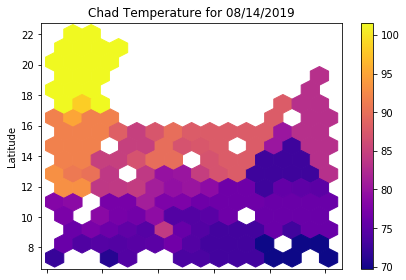

<Figure size 432x288 with 0 Axes>

In [6]:
plot_gen('Temperature')

In [15]:
map_gen('Temperature',max_intensity=150,point_radius=17)

Figure(layout=FigureLayout(height='420px'))

## Latitude vs. Humidity Plot

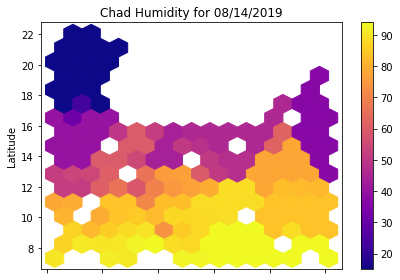

<Figure size 432x288 with 0 Axes>

In [8]:
plot_gen('Humidity')

In [9]:
map_gen('Humidity',max_intensity=125,point_radius=17)

Figure(layout=FigureLayout(height='420px'))

## Latitude vs. Cloudiness Plot

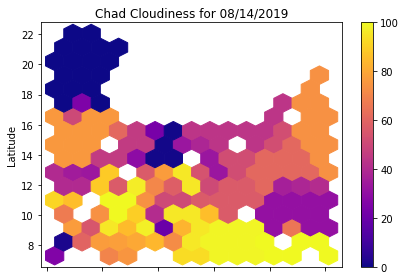

<Figure size 432x288 with 0 Axes>

In [10]:
plot_gen('Cloudiness')

In [11]:
map_gen("Cloudiness",point_radius=16,max_intensity=100)

Figure(layout=FigureLayout(height='420px'))

## Latitude vs. Wind Speed Plot

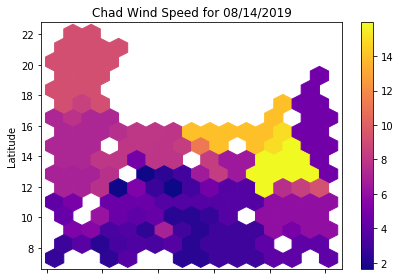

<Figure size 432x288 with 0 Axes>

In [12]:
plot_gen('Wind Speed')

In [13]:
map_gen('Wind Speed',max_intensity=20,point_radius=17)

Figure(layout=FigureLayout(height='420px'))